In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta

from plotly import graph_objects as go
from tqdm import tqdm

import logging

log = logging.Logger(name="logger", level=logging.INFO)

In [2]:
xau = pd.read_csv("data/xauusd_1h.csv", index_col="datetime", parse_dates=['datetime'])
xau.head()

,open,high,low,close,volume
datetime,,,,,
2010-01-03 22:00:00,1097.880005,1097.880005,1097.449951,1097.449951,2
2010-01-03 23:00:00,1097.680054,1100.599976,1095.979980,1095.979980,919
2010-01-04 00:00:00,1096.010010,1096.869995,1093.449951,1094.839966,1596
2010-01-04 01:00:00,1094.869995,1095.959961,1094.239990,1095.699951,869
2010-01-04 02:00:00,1095.670044,1099.150024,1095.630005,1098.329956,1054


In [3]:
xau.index[0]

Timestamp('2010-01-03 22:00:00')

In [4]:
def pivot_high(highs:pd.Series, window:int=14):
    len = highs.size
    ph = np.zeros(shape=(len, ), dtype=float)
    
    for i in range(window, len-window):
        if highs.iloc[i] == highs.iloc[i-window:i+window].max():
            ph[i] = highs.iloc[i]
    return ph

def pivot_low(lows:pd.Series, window:int=14):
    len = lows.size
    pl = np.zeros(shape=(len, ), dtype=float)
    
    for i in range(window, len-window):
        if lows.iloc[i] == lows.iloc[i-window:i+window].min():
            pl[i] = lows.iloc[i]
    return pl

In [5]:
def pivots(highs:pd.Series, lows:pd.Series, window:int) -> pd.Series:
    len = highs.size
    if lows.size != len:
        raise BufferError("`highs` and `lows` must have the same size!")
    pivots = pd.Series(data=0, index=highs.index)
    pivot_values = pd.Series(data=0, index=highs.index, dtype=np.float64)
    last_pivot = -1
    last_pivot_index = 0
    # last_pivot_value = highs.iloc[0]
    
    for i in tqdm(range(window, len-window)):
        if highs.iloc[i] == highs.iloc[i-window:i+window].max():
            if last_pivot == 1 and highs.iloc[last_pivot_index] < highs.iloc[i]:     # Previous pivot is a lower pivot high?!
                pivots.iloc[last_pivot_index] = 0       # Invalidate the previous pivot high
                pivot_values.iloc[last_pivot_index] = 0
                last_pivot_index = i                    # Set new pivot high
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = highs.iloc[last_pivot_index]
            elif last_pivot == -1:  # Previous pivot is a pivot low?!
                last_pivot_index = i            # Set pivot high
                last_pivot = 1
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = highs.iloc[last_pivot_index]
        elif lows.iloc[i] == lows.iloc[i-window:i+window].min():
            if last_pivot == -1 and lows.iloc[last_pivot_index] > lows.iloc[i]:    # Previous pivot is a higher pivot low?!
                pivots.iloc[last_pivot_index] = 0       # Invalidate the previous pivot low
                pivot_values.iloc[last_pivot_index] = 0
                last_pivot_index = i                    # Set new pivot low
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = lows.iloc[last_pivot_index]
            elif last_pivot == 1:       # Previous pivot is a pivot high
                last_pivot_index = i            # Set pivot low
                last_pivot = -1
                pivots.iloc[last_pivot_index] = last_pivot
                pivot_values.iloc[last_pivot_index] = lows.iloc[last_pivot_index]
    return pivots, pivot_values

In [33]:
xau['pivots'], xau['pivot_values'] = pivots(xau['high'], xau['low'], window=2)

100%|██████████| 89876/89876 [00:16<00:00, 5390.38it/s]


In [34]:
def plot_data(df):
    fig = go.Figure(
        data=[go.Candlestick(x=df.index,
                            close=df['close'],
                            open=df['open'],
                            low=df['low'],
                            high=df['high'])]
    )

    fig.update_layout(title="XAUUSD - H1",
                    xaxis_title="Date Time",
                    yaxis_title="Price",
                    xaxis=dict(type="category"))

    fig.show()

In [35]:
xau[xau['pivots'] == 1].index



DatetimeIndex(['2010-01-04 14:00:00', '2010-01-04 21:00:00',
               '2010-01-05 07:00:00', '2010-01-05 12:00:00',
               '2010-01-05 16:00:00', '2010-01-06 04:00:00',
               '2010-01-06 09:00:00', '2010-01-06 16:00:00',
               '2010-01-06 19:00:00', '2010-01-07 06:00:00',
               ...
               '2024-10-11 16:00:00', '2024-10-14 06:00:00',
               '2024-10-14 20:00:00', '2024-10-15 02:00:00',
               '2024-10-15 10:00:00', '2024-10-15 16:00:00',
               '2024-10-16 09:00:00', '2024-10-16 13:00:00',
               '2024-10-16 18:00:00', '2024-10-17 02:00:00'],
              dtype='datetime64[ns]', name='datetime', length=10792, freq=None)

In [36]:
xau['pivot_values'].loc[xau['pivot_values'] != 0]

datetime
2010-01-04 00:00:00    1093.449951
2010-01-04 14:00:00    1123.920044
2010-01-04 18:00:00    1115.719971
2010-01-04 21:00:00    1121.410034
2010-01-04 23:00:00    1119.770020
                          ...     
2024-10-16 16:00:00    2666.794922
2024-10-16 18:00:00    2676.760010
2024-10-16 19:00:00    2672.810059
2024-10-17 02:00:00    2684.939941
2024-10-17 03:00:00    2674.600098
Name: pivot_values, Length: 21585, dtype: float64

In [ ]:
def head_and_shoulders(df:pd.DataFrame, threshold:int, log:logging.Logger) -> pd.Series:
    # if ['pivots', 'open', 'close'] not in df.columns.to_list():
        # raise ValueError("The columns `['pivots', 'open', 'close']` must exist...")

    buy_sell = pd.Series(data=0, index=df.index)
    len = df.shape[0]
    print(len, end="\n\n\n")
    pip_value = 0.1
    
    pivots_iloc = np.where(df['pivots'] != 0)[0]
    pivots_index = df.iloc[pivots_iloc].index
    
    for i in tqdm(range(len)):
        prev_5_pivots_index = pivots_index[pivots_index < df.index[i]]
        # print(prev_5_pivots_index)
        if prev_5_pivots_index.size < 5:
            continue
        else:
            prev_5_pivots_index = prev_5_pivots_index[-5:]
        prev_5_pivots = df['pivots'].loc[prev_5_pivots_index]
        prev_5_pivot_values = df['pivot_values'].loc[prev_5_pivots_index]

        if prev_5_pivots.loc[prev_5_pivots_index[0]] == 1:
            log.info("Start pivot high on left shoulder!")
            # if np.abs(prev_5_pivot_values.iloc[0] - prev_5_pivot_values.iloc[4]) < threshold * pip_value:
            shoulders = prev_5_pivot_values.iloc[0]
            if np.abs(prev_5_pivot_values.iloc[1] - prev_5_pivot_values.iloc[3]) < threshold * pip_value:
                neck_line = prev_5_pivot_values.iloc[1]
                if prev_5_pivot_values.iloc[2] > prev_5_pivot_values.iloc[0]:
                    if df['close'].iloc[i-1] < neck_line and df['open'].iloc[i-1] > neck_line:
                        buy_sell.iloc[i] = -1   # Sell

        elif prev_5_pivots.loc[prev_5_pivots_index[0]] == -1:
                    log.info("Start pivot low on left shoulder!")
                    # if np.abs(prev_5_pivot_values.iloc[0] - prev_5_pivot_values.iloc[4]) < threshold * pip_value:
                    shoulders = prev_5_pivot_values.iloc[0]
                    if np.abs(prev_5_pivot_values.iloc[1] - prev_5_pivot_values.iloc[3]) < threshold * pip_value:
                        neck_line = prev_5_pivot_values.iloc[1]
                        if prev_5_pivot_values.iloc[2] < prev_5_pivot_values.iloc[0]:
                            if df['close'].iloc[i-1] > neck_line and df['open'].iloc[i-1] < neck_line:
                                buy_sell.iloc[i] = 1   # Buy
    return buy_sell

In [38]:
log.setLevel(logging.INFO)
buy_sell = head_and_shoulders(xau, 10, log=log)

89880




100%|██████████| 89880/89880 [01:06<00:00, 1358.75it/s]


In [40]:
xau['buy_sell'] = buy_sell

buy_sell.loc[buy_sell != 0].count()

396

In [41]:
buy_sell.index.size, xau.index.size

(89880, 89880)

In [42]:

def plot_candlestick(df:pd.DataFrame):
    fig = go.Figure(data=[go.Candlestick(
        x=df.index,
        close=df.close,
        open=df.open,
        high=df.high,
        low=df.low,
        # name="XAU_USD -- H1 -- OANDA",
        )])

    fig.update_layout(
        width=1200,
        height=800,
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(type='category',
                   showgrid=False,
                   zeroline=False),
        yaxis=dict(showgrid=False,
                   zeroline=False)
    )

    fig.show()

In [43]:
plot_candlestick(xau.iloc[0:500])

In [44]:
xau_cap = xau.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

In [52]:
import backtrader as bt
from backtesting.backtesting import Strategy
from backtesting.lib import Sequence

class SIGNAL(bt.Indicator):
    lines = ('signal', )
    params = ()
    def __init__(self):
        self.lines.signal = bt.feeds.PandasData(dataname=pd.DataFrame(xau['buy_sell'], columns=['buy_sell']))

def signal():
    return xau['buy_sell']


class HnSStrategy(Strategy):       
    sl_points = 400
    point_size = .01
    rrr = 2.5
    lot_size = 0.1

    def init(self):
        super().init()
        self.signal = self.I(signal, name="BUY/SELL")

    def next(self):
        super().next()
        if self.position:
            return

        if self.signal == -1:
            sl = self.data.Close[-1] + self.sl_points * self.point_size
            print(self.data.Close[-1])
            tp = self.data.Close[-1] - self.rrr * self.sl_points * self.point_size
            self.sell(size=self.lot_size, sl=sl, tp=tp, limit=None)
        elif self.signal == 1:
            sl = self.data.Close[-1] - self.sl_points * self.point_size
            print(self.data.Close[-1])
            tp = self.data.Close[-1] + self.rrr * self.sl_points * self.point_size
            self.buy(size=self.lot_size, sl=sl, tp=tp, limit=None)

In [53]:
from backtesting.backtesting import Backtest

params = {'sl_points': 200,
          'rrr': 1.5}

bt = Backtest(data=xau_cap, strategy=HnSStrategy, cash=100_000.0, commission=0)

results = bt.run()

1126.1199951171875
1132.300048828125
1139.364990234375
1101.4749755859375
1087.1949462890625
1092.8299560546875
1076.4200439453125
1086.1199951171875
1092.68505859375
1119.31005859375
1125.2900390625
1144.6600341796875
1139.2900390625
1209.27001953125
1222.10498046875
1255.89501953125
1237.030029296875
1231.574951171875
1223.9599609375
1353.5550537109375
1343.260009765625
1403.0799560546875
1394.6800537109375
1385.56005859375
1419.9949951171875
1348.9300537109375
1399.030029296875
1418.25
1397.1949462890625
1440.050048828125
1430.56005859375
1486.77001953125
1519.803955078125
1480.0140380859375
1521.9090576171875
1530.7120361328125
1522.22900390625
1556.8260498046875
1499.93896484375
1502.3389892578125
1599.23095703125
1600.613037109375
1587.3170166015625
1793.4549560546875
1824.217041015625
1852.5880126953125
1693.6319580078125
1741.8890380859375
1739.344970703125
1710.9189453125
1639.553955078125
1661.6610107421875
1715.4329833984375
1719.5810546875
1658.4119873046875
1666.2080078125

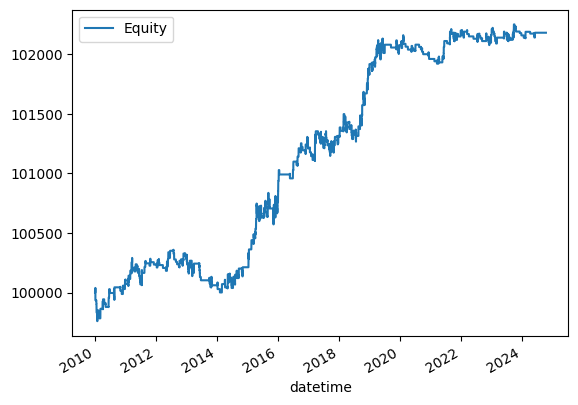

In [54]:
from matplotlib import pyplot as plt

results['_equity_curve'].plot(y='Equity')
plt.show()


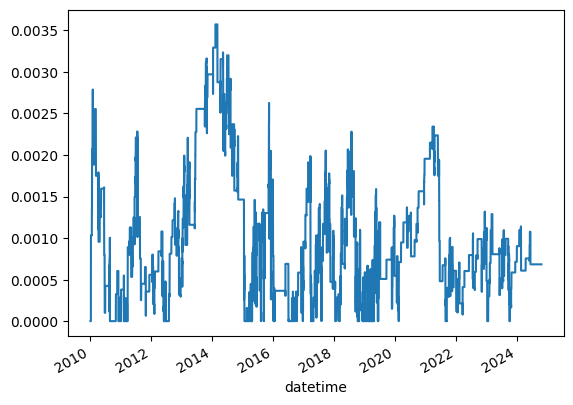

In [55]:
results['_equity_curve']['DrawdownPct'].plot()
plt.show()